In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## References and data download info

Setting up and activating a conda environmnt:
https://github.com/spacetelescope/jwst#installing-latest-releases

I called the "release" version environmeent "jwst_release"
To activate, I can type:
conda activate jwst_release

First Image observations:

https://www.stsci.edu/jwst/science-execution/approved-programs/webb-first-image-observations

ERS programs:

https://www.stsci.edu/jwst/science-execution/approved-ers-programs

Command to download MIRI IFU level 2 products from ERS program 1328: PI Armus

see https://github.com/spacetelescope/jwst_mast_query

jwst_download.py -v -c jwst_query.cfg -l 200 --propID 01328 --makewebpages --filetypes cal --sca mirifulong mirifushort

pipeline suffix definitions:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#pipeline-step-suffix-definitions

"cal" = calibrated image

Data reduction Webbinars here:

https://www.stsci.edu/jwst/science-execution/jwebbinars

See David Law's video here:

https://www.youtube.com/watch?v=gdM9M9o35Uo&ab_channel=JWSTObserver

spectroscopic mode github repository

https://github.com/spacetelescope/jwebbinar_prep/tree/webbinar4/spec_mode

## Setup

### Python imports

In [2]:
# Basic system utilities for interacting with files
import glob, sys, os, time, shutil, warnings

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Matplotlib for making plots
from matplotlib import rc

In [3]:
# Import the base JWST package and print version
import jwst

print('JWST pipeline version',jwst.__version__)

JWST pipeline version 1.3.3


In [4]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# Individual JWST pipeline steps
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.srctype import SourceTypeStep
from jwst.straylight import StraylightStep
from jwst.fringe import FringeStep
from jwst.photom import PhotomStep
from jwst.cube_build import CubeBuildStep
from jwst.extract_1d import Extract1dStep
from jwst.cube_skymatch import CubeSkyMatchStep
from jwst.master_background import MasterBackgroundStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.extract_1d import Extract1dStep

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

# If using pipeline version 1.2.0 or later, the dqflags function is contained in the 'stcal' product
from stcal import dqflags # Utilities for working with the data quality (DQ) arrays

### Data directories, etc

In [5]:
data_dir = '/Users/cosalyk/DATA/JWST/01328/'

In [6]:
# Specify some working directories to use so that everything is more organized.<br>
spec2_dir = data_dir+'stage2/' # Spec2 pipeline outputs will go here
spec3_dir = data_dir+'stage3/' # Spec3 pipeline outputs will go here

## Investigate level 2 ("cal") files

###  Check for files

In [7]:
# Look for our downloaded cal.fits files
sstring = spec2_dir + '*cal.fits'
calfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
print(np.size(calfiles))
print(calfiles[0],calfiles[1])

96
/Users/cosalyk/DATA/JWST/01328/stage2/jw01328015001_02101_00001_mirifulong_cal.fits /Users/cosalyk/DATA/JWST/01328/stage2/jw01328015001_02101_00001_mirifushort_cal.fits


### Investigate data

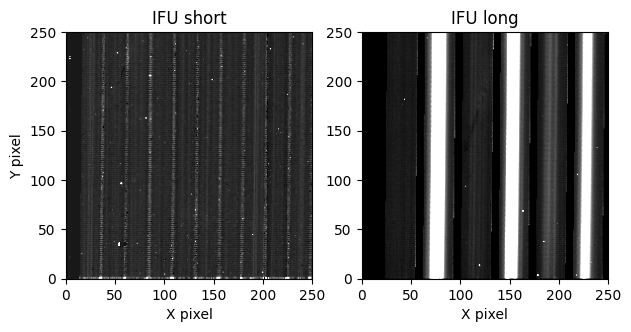

In [8]:
hdu1 = fits.open(calfiles[1])  #"ifushort"
image1 = hdu1['SCI'].data
header1 =  hdu1['SCI'].header

hdu2 = fits.open(calfiles[0])  #"ifulong"
image2 = hdu2['SCI'].data
header2 =  hdu2['SCI'].header

# Use a classic ZScale normalization
norm1 = ImageNormalize(image1, interval=ZScaleInterval(), stretch=LinearStretch())
norm2 = ImageNormalize(image2, interval=ZScaleInterval(), stretch=LinearStretch())

#Define axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', origin='lower', norm=norm1)
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')
ax1.set_title('IFU short')
ax1.set_xlim(0, 250)
ax1.set_ylim(0, 250)

ax2.imshow(image2, cmap='gray', origin='lower', norm=norm2)
ax2.set_xlabel('X pixel')
ax2.set_title('IFU long')
ax2.set_xlim(0, 250)
ax2.set_ylim(0, 250)

hdu1.close()
hdu2.close()

Here's a reminder of what's appearing in these images. There are two channels on each image, and each vertical stripe is one strip across the IFU, as shown for Ch4 in the figure on the left. 

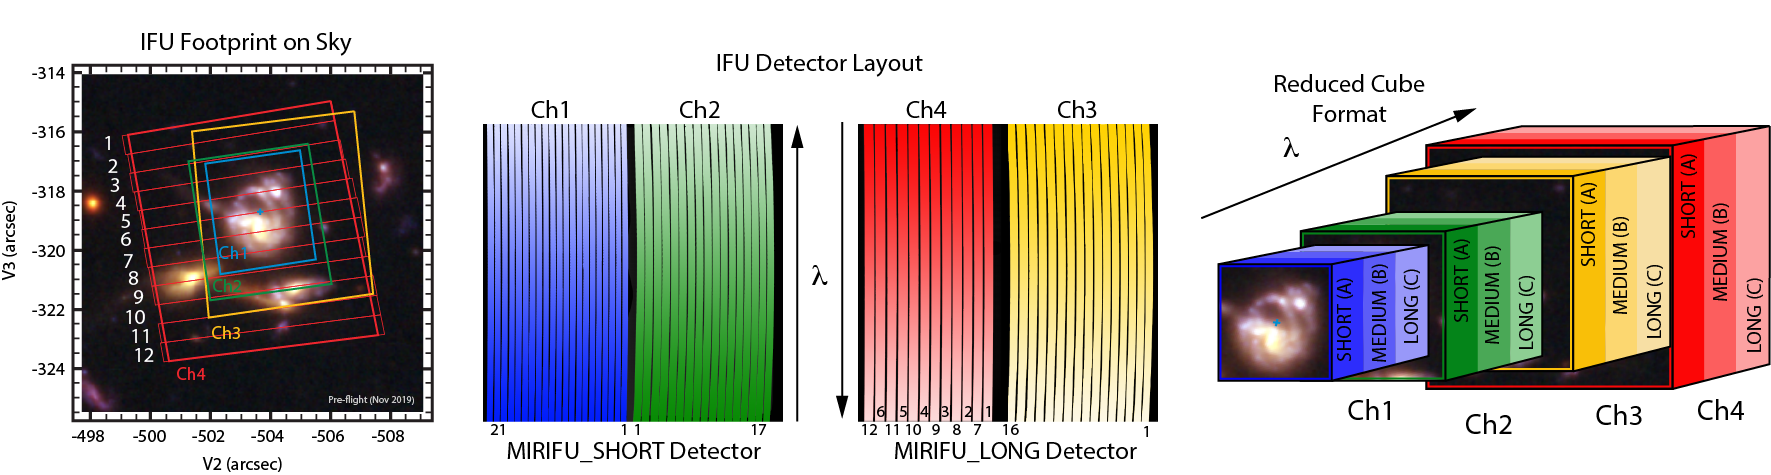

## Data Reduction

### <font color='white'>-</font>Quicklook Cube Building <a class="anchor" id="spec2cube"></a> ###


<div class="alert alert-block alert-warning">
Now that we've got fully calibrated 2d detector-level data (\_photom.fits if we've run the pipeline step by step, \_cal.fits if we simply ran the spec2 pipeline as a whole) the pipeline builds some simple data cubes from each exposure.  These are multi-band data cubes that combine data from both channels on a given detector into a single data cube with a large blank region in the middle corresponding to the gap between the bands (e.g., it would create a 1A+2A data cube from the SHORT wavelength detector with the SHORT grating setting, and have an empty gap corresponding to the 1B+1C wavelength range).

We won't generally want to interact with these cubes much; they're big, unwieldy, and since they're for single exposures they aren't well sampled.  However, at the moment they're used to populate the background flux information that will be used in the Master Background step in the Spec3 pipeline and are thus necessary to produce.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/index.html
</div>

In [9]:
# Look for our downloaded cal.fits files
sstring = spec2_dir + '*cal.fits'
calfiles = sorted(glob.glob(sstring))

In [10]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in calfiles:
    # Note that the 'multi' makes this function like in the spec2 pipeline
    CubeBuildStep.call(file, output_type='multi', save_results=True, output_dir=spec2_dir)

2022-07-22 16:31:34,522 - stpipe - WARNING - /Users/cosalyk/anaconda3/lib/python3.7/site-packages/asdf/entry_points.py:55: AsdfWarning: asdf_extensions plugin from package jwst==1.3.3 failed to load:

VersionConflict: (photutils 1.3.0 (/Users/cosalyk/anaconda3/lib/python3.7/site-packages), Requirement.parse('photutils<1.2,>=1.1.0'))
  AsdfWarning,

2022-07-22 16:31:34,903 - stpipe - WARNING - Input dataset is not an instance of  AbstractDataModel.
2022-07-22 16:31:34,904 - stpipe - INFO - PARS-CUBEBUILDSTEP: CRDS parameter reference retrieval disabled.
2022-07-22 16:31:34,912 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2022-07-22 16:31:35,036 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args ('/Users/cosalyk/DATA/JWST/01328/stage2/jw01328015001_02101_00001_mirifulong_cal.fits',).
2022-07-22 16:31:35,040 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/

FileNotFoundError: Unable to fetch schema from non-file URL: http://stsci.edu/schemas/jwst_datamodel/ifuimage.schema